<a href="https://colab.research.google.com/github/ankesh86/IntroductionToMachineLearning/blob/main/ASSGN_q3_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00


# **Wine(white) Dataset**

## **Import Libraries**

In [81]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

## **Load file data**

In [82]:
wine_df = pd.read_csv("winequality-white.csv", sep=';')
wine_df["quality"].unique()

array([6, 5, 7, 8, 4, 3, 9])

In [83]:
label = "quality"
features_df = wine_df.drop(columns=['quality'])

In [84]:
def compute_regularized_covariance(data_matrix, regularization_factor):
    """
    Compute the regularized covariance matrix of a given data matrix.

    Args:
        data_matrix (np.ndarray): The data matrix where each row represents an observation
                                  and each column represents a variable.
        regularization_factor (float): The regularization parameter used to stabilize
                                       the covariance matrix.

    Returns:
        np.ndarray: The regularized covariance matrix.
    """
    empirical_cov = np.cov(data_matrix, rowvar=False)
    dimension = data_matrix.shape[1]
    # Apply regularization to the covariance matrix
    regularized_cov = empirical_cov + regularization_factor * np.eye(dimension)
    return regularized_cov

## **Pre-processing data**

In [85]:
# Access rows/columns by indexing
X = wine_df.iloc[:, :-1].to_numpy()
qualities = wine_df.iloc[:, -1].to_numpy()

# Define a label encoder to encode labels numerically
le = preprocessing.LabelEncoder()
labels = le.fit_transform(qualities)  # Fit and transform in one step

# Estimate class priors
class_priors = wine_df['quality'].value_counts(normalize=True).sort_index().to_numpy()
no_of_classes = len(class_priors)

In [86]:
# Calculate mean vectors
grouped = wine_df.groupby('quality')
mean_vectors = grouped.mean().to_numpy()

# Regularization parameter
regularization_factor_reg = 1 / wine_df.shape[1]  # Example regularization, can be tuned

# Compute regularized covariance matrices for each class
regularized_cov_matrix = np.array([
    compute_regularized_covariance(X[labels == l], regularization_factor_reg)
    for l in range(no_of_classes)
])

# Number of samples per class
sample_per_class = grouped.size().to_numpy()


In [87]:
gmm = {
    'priors': class_priors,
    'mu': mean_vectors,
    'cov_matrix': regularized_cov_matrix
}

print(sample_per_class)

[  20  163 1457 2198  880  175    5]


In [88]:
from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [89]:
def calculate_class_conditional_likelihoods(X, gmm_data, no_of_classes):
    """
    Compute the likelihood of data given each class.

    Args:
        X (np.ndarray): The dataset for which likelihoods are calculated.
        gmm_data (dict): Gaussian mixture model parameters with keys 'mu', 'cov_matrix'.
        no_of_classes (int): Number of unique classes.

    Returns:
        np.ndarray: Likelihoods of each class given the data.
    """
    return np.array([
        multivariate_normal.pdf(X, mean=gmm_data['mu'][i], cov=gmm_data['cov_matrix'][i])
        for i in range(no_of_classes)
    ])
def calculate_posteriors(likelihoods, priors):
    """Calculate posterior probabilities using Bayes' rule."""
    priors_diagonal = np.diag(priors)
    return priors_diagonal.dot(likelihoods)

def calculate_risks(posteriors, loss_matrix):
    """Calculate risks for each class and sample."""
    return loss_matrix.dot(posteriors)

def classify(risks):
    """Classify data points into the class with minimum risk."""
    return np.argmin(risks, axis=0)

def classifiy_erm(X, regularization_factor, gmm_data, no_of_classes):
    """
    Perform Empirical Risk Minimization (ERM) classification based on Gaussian mixture model parameters.

    Args:
        X (np.ndarray): Data points to classify.
        regularization_factor (np.ndarray): Loss matrix.
        gmm_data (dict): Parameters of the Gaussian Mixture Model including 'mu', 'cov_matrix', and 'priors'.

    Returns:
        np.ndarray: Predicted class labels for each data point.
    """
    #no_of_classes = len(gmm_data['priors'])  # Explicitly calculating the number of classes
    likelihoods = calculate_class_conditional_likelihoods(X, gmm_data, no_of_classes)
    posteriors = calculate_posteriors(likelihoods, gmm_data['priors'])
    risks = calculate_risks(posteriors, regularization_factor)
    return classify(risks)

In [90]:
%matplotlib widget
from sys import float_info  # Threshold smallest positive floating value
import matplotlib.pyplot as plt # For general plotting

In [91]:
from google.colab import output
output.enable_custom_widget_manager()

## **Calculating confusion matrix**

Confusion Matrix (rows: Predicted class, columns: True class):


Text(0.5, 0, 'True Labels')

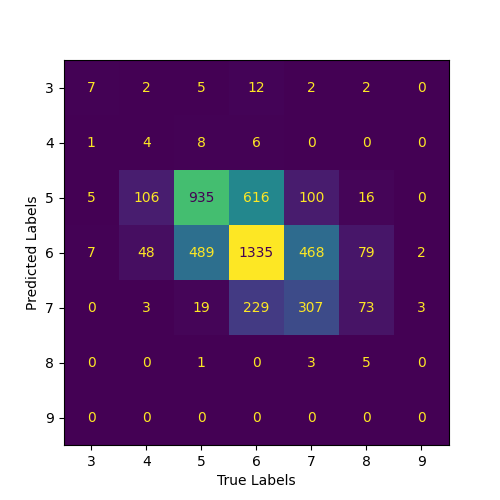

In [92]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
regularization_factor = np.ones((no_of_classes, no_of_classes)) - np.eye(no_of_classes)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = classifiy_erm(X, regularization_factor, gmm, no_of_classes)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
fig, ax = plt.subplots(figsize=(5, 5))
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, ax=ax, display_labels=['3', '4', '5', '6', '7', '8', '9'], colorbar=False)
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')

In [93]:
# Total number of rows/samples
N = len(wine_df.index)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total number of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Total number of Misclassified Samples: 2305
Empirically Estimated Probability of Error: 0.4706


#### Calculating co-relation

In [94]:
numeric_wine_df = wine_df.select_dtypes(include=[np.number])
corr_matrix = numeric_wine_df.corr()
corr_matrix["quality"].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64

## **3-D Plot of top-3 correleated factors with label**

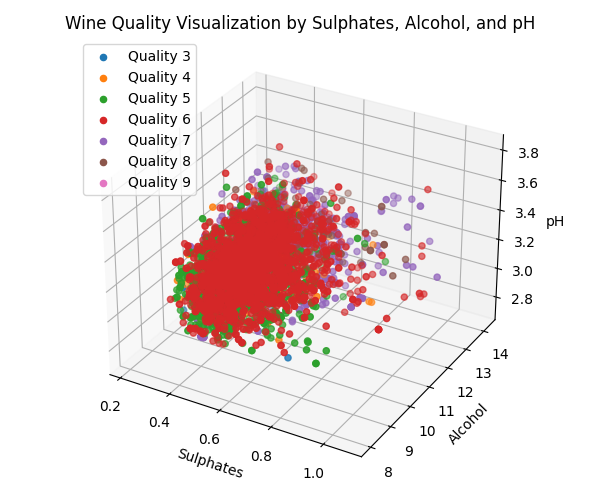

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming wine_df is already defined and loaded
fig = plt.figure(figsize=(6, 5))  # Define the figure size
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot

# Get unique qualities and sort them
unique_qualities = np.sort(wine_df['quality'].unique())

# Iterate through the sorted unique qualities
for q in unique_qualities:
    subset = wine_df[wine_df['quality'] == q]
    ax.scatter(subset['sulphates'], subset['alcohol'], subset['pH'], label=f"Quality {q}")

# Set labels for each axis based on the features being plotted
ax.set_xlabel("Sulphates")
ax.set_ylabel("Alcohol")
ax.set_zlabel("pH")

# Add a title and a legend to the plot
plt.title("Wine Quality Visualization by Sulphates, Alcohol, and pH")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## **PCA Decomposition**

Explained variance ratio: [0.90965734 0.07933386 0.01015427]


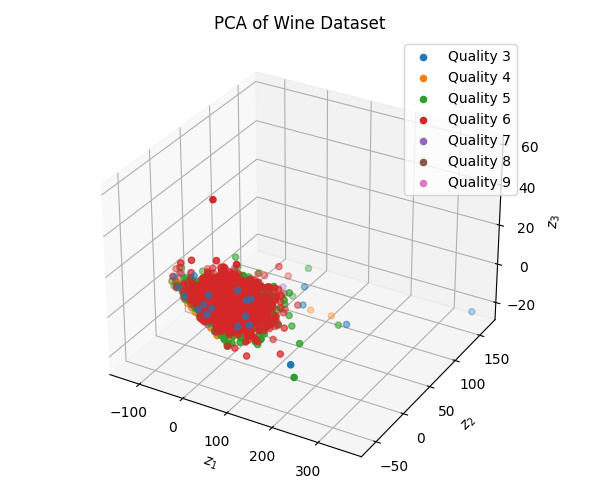

In [96]:
from sklearn.decomposition import PCA

# Initialize PCA and fit the data
pca = PCA(n_components=3)
pca.fit(X)

# Transform the data using PCA
Z = pca.transform(X)

# Check how much variance is explained by the first three components
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Create a 3D scatter plot
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# Iterate over unique qualities to plot each class in different colors
unique_qualities = sorted(wine_df['quality'].unique())
for quality in unique_qualities:
    # Select rows where 'quality' equals the current quality
    mask = wine_df['quality'] == quality
    ax.scatter(Z[mask, 0], Z[mask, 1], Z[mask, 2], label=f"Quality {quality}")

ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.set_zlabel(r"$z_3$")

# Add a plot title and a legend
plt.title("PCA of Wine Dataset")
plt.legend()

# Adjust layout to make sure there's no clipping
plt.tight_layout()
plt.show()

# **Human Activity Recognition - Dataset**

## **Loading dataset**

In [97]:
feature_df = pd.read_csv("X_train.txt", header=None, delim_whitespace=True)
label_df = pd.read_csv("y_train.txt", header=None, delim_whitespace=True)
headers =  pd.read_csv("features.txt", header=None, delim_whitespace=True)

column_names = headers.iloc[:, 1].tolist()
# Now assign these names to the columns of feature_df
feature_df.columns = column_names
# Optionally, you can display the first few rows to confirm the column names are set correctly
print(feature_df.head(1))

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-meanFreq()  \
0         -0.923527         -0.934724  ...                        -0.074323   

   fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
0                        -0.298676                        -0.710304   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                    -0.112754                                0.0304   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                         -0.464761                             -0.018446   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  
0           

## **Pre-processing**

In [98]:
# Access rows/columns by indexing
X = feature_df.to_numpy()
Y = label_df.to_numpy()

# Define a label encoder to encode labels numerically
le = preprocessing.LabelEncoder()
labels = le.fit_transform(Y)  # Fit and transform in one step

# Estimate class priors
unique_classes, counts = np.unique(Y, return_counts=True)
class_priors = counts / counts.sum()  # Normalize counts to sum to 1
no_of_classes = len(unique_classes)

# Print results to verify
print("Class Priors:", class_priors)
print("Number of Classes:", no_of_classes)

Class Priors: [0.16675734 0.14594668 0.13411317 0.17491839 0.18688792 0.1913765 ]
Number of Classes: 6


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## **Setting Regularization, assumint it to be 5/531 as it alters the missclassification, in Wine dataset, took 1/6**

In [99]:
mean_vectors = np.array([X[labels == i].mean(axis=0) for i in range(no_of_classes)])

regularization_factor_reg = 5 / X.shape[1]  # Regularization, tuned to reduce error


regularized_cov_matrix = np.array([
    compute_regularized_covariance(X[labels == l], regularization_factor_reg)
    for l in range(no_of_classes)
])

# Number of samples per class
sample_per_class = counts
print(f"Regularization factor: {regularization_factor_reg}")


Regularization factor: 0.008912655971479501


In [100]:
gmm = {
    'priors': class_priors,
    'mu': mean_vectors,
    'cov_matrix': regularized_cov_matrix
}

print(sample_per_class)


[1226 1073  986 1286 1374 1407]


## **Confusion matrix plot**

Confusion Matrix (rows: Predicted class, columns: True class):


Text(0.5, 0, 'True Labels')

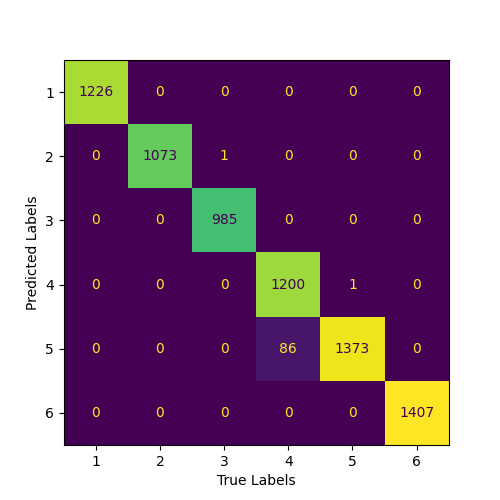

In [101]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((no_of_classes, no_of_classes)) - np.eye(no_of_classes)

# If 0-1 loss then yield MAP decision rule, else ERM classifier
regularization_factor = np.ones((no_of_classes, no_of_classes)) - np.eye(no_of_classes)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = classifiy_erm(X, regularization_factor, gmm, no_of_classes)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
fig, ax = plt.subplots(figsize=(5, 5))
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, ax=ax, display_labels=['1', '2', '3', '4', '5', '6'], colorbar=False)
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')

In [102]:
# Total number of rows/samples
N = len(feature_df.index)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total number of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Total number of Misclassified Samples: 88
Empirically Estimated Probability of Error: 0.0120


In [103]:
#HAR_df = pd.concat([X, Y], axis=1)
label_df.rename(columns={label_df.columns[0]: 'label'}, inplace=True)
HAR_df = pd.concat([feature_df, label_df], axis=1)

numeric_HAR_df = HAR_df.select_dtypes(include=[np.number])
corr_matrix = numeric_HAR_df.corr()
top_5_correlations = corr_matrix["label"].sort_values(ascending=False).head(5)

print("Top 5 positive correlations with 'label':")
print(top_5_correlations)

Top 5 positive correlations with 'label':
label                   1.000000
tBodyAccJerk-min()-Y    0.788595
tBodyAccJerk-min()-X    0.786288
tBodyAcc-min()-Y        0.771205
tBodyGyro-min()-Z       0.758051
Name: label, dtype: float64


## **Plotting top-3 correlated columns with label**

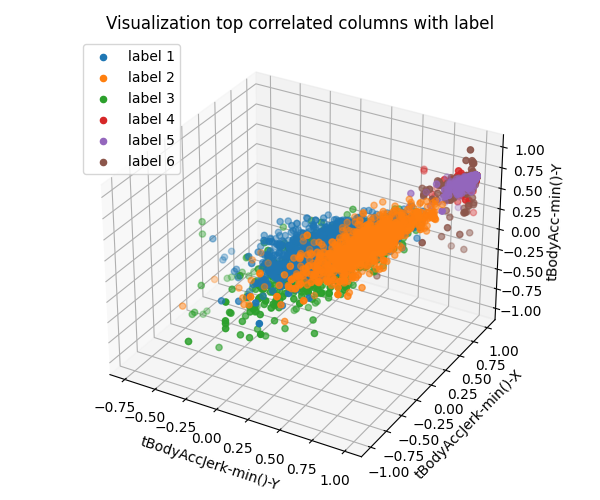

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming wine_df is already defined and loaded
fig = plt.figure(figsize=(6, 5))  # Define the figure size
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot

# Get unique qualities and sort them
unique_qualities = np.sort(HAR_df['label'].unique())

# Iterate through the sorted unique qualities
for q in unique_qualities:
    subset = HAR_df[HAR_df['label'] == q]
    ax.scatter(subset['tBodyAccJerk-min()-Y'], subset['tBodyAccJerk-min()-X'], subset['tBodyAcc-min()-Y'], label=f"label {q}")

# Set labels for each axis based on the features being plotted
ax.set_xlabel("tBodyAccJerk-min()-Y")
ax.set_ylabel("tBodyAccJerk-min()-X")
ax.set_zlabel("tBodyAcc-min()-Y")

# Add a title and a legend to the plot
plt.title("Visualization top correlated columns with label")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## **PCA Decomposition**

Explained variance ratio:  [0.6255444  0.04913023 0.04121467]


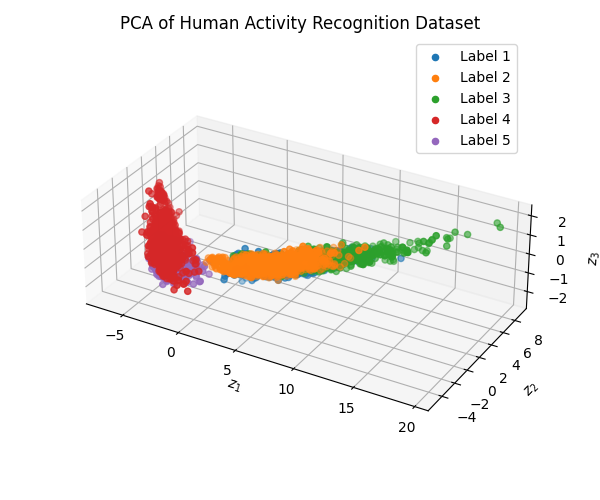

In [105]:
fig = plt.figure(figsize=(6, 5))

ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components of PCA
X_fit = pca.fit(X)
Z = pca.transform(X)

# first principal component accounts for approximately 62.55% of the variance in the data.
print("Explained variance ratio: ", pca.explained_variance_ratio_)

for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_pca.scatter(Z[HAR_df['label']==q, 0],
                      Z[HAR_df['label']==q, 1],
                      Z[HAR_df['label']==q, 2], label="Label {}".format(q))

ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of Human Activity Recognition Dataset")
plt.legend()
plt.tight_layout()
plt.show()

#Output - Explained variance ratio:  [0.6255444  0.04913023 0.04121467]

# END

In [70]:
##

In [71]:
##

In [72]:
##

In [73]:
##

In [74]:
##

In [75]:
##

In [76]:
##

In [77]:
##

In [78]:
##

In [79]:
##

In [80]:
##